In [25]:
from astropy.io import fits
import astropy.units as u
from astroquery import ned
from astropy.wcs import wcs
from astropy.coordinates import SkyCoord
from astropy.table import Table, vstack, hstack
import numpy as np
import tables
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import ceil

In [26]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [27]:
# This is a cell with all self-defined functions
def coord_NED(dwarfname):
    from astroquery.ned.core import RemoteServiceError
    # get rid of the weird symbos *, (, ), etc, since NED doens't like it
    newname = dwarfname.replace('*','').replace('(','').replace(')', '')

    try:
        target = ned.Ned.query_object(newname)
        ned_exist = True
    except RemoteServiceError: 
        print('NED does not have info, skip: %s/%s\n'%(dwarfname, newname))
        ned_exist= False 
    
    if ned_exist == False:
        tRA, tDEC, tVel, tDist = np.nan, np.nan, np.nan, np.nan
    else: # if NED does have this target, then extract coordinates
        tRA = target["RA(deg)"].data.data[0]
        tDEC = target["DEC(deg)"].data.data[0]
        tVel = target["Velocity"].data.data[0]
        tDist = target["Distance (arcmin)"].data.data[0]
    return tRA, tDEC, tDist, tVel, ned_exist

## transform from vhelio to vlsr 
def vhelio2vlsr_Westmeier(vel_init, ral, decb, reverse=False, doradec=True):
    '''
    - from http://www.atnf.csiro.au/people/Tobias.Westmeier/tools_hihelpers.php
    - obj_ra:  should be in degree
    - obj_dec: should be in degree
    - vel_init: velocity that need to be transformed
    -          vel_init = vhelio if reverse = False
    -          vel_init = vlsr   if reverse = True
    - Favor this one than the other one from Rosolowsky
    '''
    from astropy.coordinates import SkyCoord
    import numpy as np

    if doradec==True:
        c = SkyCoord(ral, decb, unit='deg')
        l = np.radians(c.galactic.l.value)
        b = np.radians(c.galactic.b.value)
    else:
        l = np.radians(ral)
        b = np.radians(decb)
    # vlsr 00> vhelio
    if reverse:
        delv = -(9*np.cos(l)*np.cos(b)+12*np.sin(l)*np.cos(b)+7*np.sin(b))
    else:
        delv = +9*np.cos(l)*np.cos(b)+12*np.sin(l)*np.cos(b)+7*np.sin(b)

    # print 'Velocity correction at this (RA, DEC) is (km/s): ', delv
    return vel_init+delv


def find_the_cube(ra, dec, observation='HI4PI'):
    '''
    Use the input (ra, dec) to decide which cube the data locates.

    observation: most of the time, it is HI4PI or GALFA-HI . 
    
    Note: GALFA-HI table is not available now, will do later 
    '''

    clt = Table.read('tables/%s_RADEC.dat'%(observation), format='ascii')
    cramin, cramax = clt['min_ra'], clt['max_ra']
    cdcmin, cdcmax = clt['min_dec'], clt['max_dec']
    indra = np.all([ra>cramin, ra<cramax], axis=0)
    inddc = np.all([dec>cdcmin, dec<cdcmax], axis=0)
    indall = np.where(np.all([indra, inddc], axis=0) == True)

    cubename = clt['cubename'][indall]
    if len(cubename)==0:
        return ''
    else:
        cubename = cubename[0]

        return cubename
    
import sys
import astropy.wcs as wcs
import numpy as np


# a function to read in header and generate RA, DEC and VLSR array
def get_cubeinfo(header, returnHeader=False):
    '''
    A function created to parse the RA, DEC, (and velocity) information from the 2D (3D) header

    - This function has been tested with GALFA-HI/EBHIS cubes, and GALFA-HI 2D images.
    -               also been tested with LAB cubes/images that are in (glon, glat) coordinates.
    - The input header can be 2D: NAXIS=2. NAXIS1 is RA (glon), 2 is DEC (glat)
    -                      or 3D: NAXIS=3. NAXIS1 is RA (glon), 2 is DEC (glat), 3 is Velocity
    - Return: if GALFA-HI or EBHIS:
                        ra and dec in 2D, with shape of (dec.size, ra.size) or (NAXIS2, NAXIS1)
    -                   velocity in 1D.
                        or (ra, dec, vlsr, header array)
    -         if LAB:
                        glon, glat in 2D, with shape of (glat.size, glon.size) or (NAXIS2, NAXIS1)
    -                   velocity in 1D.
                        or (gl, gb, vlsr, header array)
    - History: updated as of 2016.10.03. Yong Zheng @ Columbia Astro.
    '''


    hdrarrs = []
    if header['NAXIS'] == 2:
        hdr2d = header.copy()
        hdrarrs.append(hdr2d)
    elif header['NAXIS'] == 3:
        # create a 2D header (RA/DEC) to speed up the RA/DEC calculation using astropy.wcs
        hdr2d = header.copy()
        # we don't need the velocity (3) information in the header
        delkey = []
        for key in hdr2d.keys():
            if len(key) != 0 and key[-1] == '3': delkey.append(key)
        for i in delkey: del hdr2d[i]

        hdr2d['NAXIS'] = 2
        if 'WCSAXES' in hdr2d.keys(): hdr2d['WCSAXES']=2
        # create a 1D header (vel) to parse the velocity using astropy.wcs
        hdr1d = header.copy()
        # we don't need the RA/DEC keywords info in the header now.
        delkey = []
        for keya in hdr1d.keys():
            if len(keya) != 0 and keya[-1] in ['1', '2']: delkey.append(keya)
        for i in delkey: del hdr1d[i]
        delkey = []
        for keyb in hdr1d.keys():
            if len(keyb) != 0 and keyb[-1] == '3':
                hdr1d.append('%s1'%(keyb[:-1]))
                hdr1d['%s1'%(keyb[:-1])] = hdr1d[keyb]
                delkey.append(keyb)
        for i in delkey: del hdr1d[i]
        hdr1d['NAXIS'] = 1
        if 'WCSAXES' in hdr1d.keys(): hdr1d['WCSAXES']=1

        # save header arrays
        hdrarrs.append(hdr2d)
        hdrarrs.append(hdr1d)
    else:
        print("This code can only handle 2D or 3D data")
        sys.exit(1)

    return_arrays = []

    # calculate RA, DEC
    gwcsa = wcs.WCS(hdr2d)
    n1, n2 = hdr2d['NAXIS1'], hdr2d['NAXIS2']
    ax = np.reshape(np.mgrid[0:n1:1]+1, (1, n1))  # For FITS standard, origin = 1
    ay = np.reshape(np.mgrid[0:n2:1]+1, (n2, 1))  #   then for numpy standard, origin = 0
    coor1, coor2 = gwcsa.all_pix2world(ax, ay, 1) # coor1 = ra  or glon
    return_arrays.append(coor1)                   # coor2 = dec or glat
    return_arrays.append(coor2)

    ## calculate VLSR
    if header['NAXIS'] == 3:
        gwcsb = wcs.WCS(hdr1d)
        n1 = hdr1d['NAXIS1']
        ax = np.mgrid[0:n1:1]+1
        # ax = np.linspace(0, n1, n1)  # nope, wrong
        vel = gwcsb.all_pix2world(ax, 1)[0]
        if 'CUNIT1' in hdr1d.keys():
            if hdr1d['CUNIT1'] in ['m/s', 'M/S', 'M/s', 'm/S']:
                vel = vel/1e3
        else: vel = vel/1e3  # default is usually in m/s
        return_arrays.append(vel)

    if returnHeader == True: return_arrays.append(hdrarrs)
    return return_arrays

In [28]:
def ellipse_mask_cube(semi_a, semi_b, PA, tar_x, tar_y, cube_header, extend_pix = 0):
    ## make ellipse based on the semi major/minor axies and position angle of the targets 
    
    cube_wh = cube_header['NAXIS1']  # RA
    cube_ht = cube_header['NAXIS2']  # DEC
    x1d = np.arange(cube_wh)
    y1d = np.arange(cube_ht)
    x2d, y2d = np.meshgrid(x1d, y1d)

    # center at the source 
    x2d_nc, y2d_nc = x2d-tar_x, y2d-tar_y

    # this is a rough pixel length for the semimajor and semiminor axis
    semi_a_pix = ceil(abs(semi_a / cube_header['CDELT1']))
    semi_b_pix = ceil(abs(semi_b / cube_header['CDELT1']))
    
    #phi = np.radians(90-PA) changing 
    phi = np.radians(90+PA)

    # transform to new coordinate system
    xx_prime = x2d_nc*np.cos(phi) + y2d_nc*np.sin(phi)
    yy_prime = -x2d_nc*np.sin(phi) + y2d_nc*np.cos(phi)

    mask_ep = ((xx_prime/(semi_a_pix+extend_pix))**2 + (yy_prime/(semi_b_pix+extend_pix))**2)<=1 
    return mask_ep

In [29]:
def find_info(objname):
    from astropy.table import Table 
    tb = Table.read('/Users/amalyajohnson/Desktop/astro/Dwarf Galaxies/dwarfgalcomplete.txt', format='ascii')
    
    newname = objname.replace('*','').replace('(','').replace(')', '').replace(' ', '')
    for i, iname in enumerate(tb['GalaxyName']):
        i_tbnewname = iname.replace('*','').replace('(','').replace(')', '').replace(' ', '')
        
        if newname == i_tbnewname:
            find_it = True
            break
        else: 
            find_it = False
            
    if find_it == True:
        print('YES, we find it!!!', tb['RA'][i], tb['DEC'][i], tb['vh(m/s)'][i])
        return tb['RA'][i], tb['DEC'][i], tb['vh(m/s)'][i], tb['rh(arcmins)'][i], tb['e=1-b/a'][i], tb['PA'][i]
    else:
        print('Sorry, not there, check your object name. ')
        return np.nan, np.nan, np.nan
    

# Galaxy Info

In [194]:
objname = 'UrsaMajorI' 

objRA, objDEC, objV_helio, a, ecc, PA = find_info(objname)
vcoord = vhelio2vlsr_Westmeier(0, objRA, objDEC, doradec=True) #in km/s
objV = objV_helio + vcoord*1e3
semi_b = (1 - ecc)*a/60 #degree, semi minor axis
semi_a = a/60 #degree, semi major axis

YES, we find it!!! 158.717 51.92 -55300


In [195]:
cubename = '/Users/amalyajohnson/Desktop/datacubes/HI4PI/CAR_h08.fits' #pull cube from directory
img1 = fits.getdata(cubename)
hdr = fits.getheader(cubename)

In [196]:
# setting up the WCS
wcsleop =  wcs.WCS(hdr)

# converting to pixel space
tar_x, tar_y, tar_v = wcsleop.all_world2pix(objRA, objDEC, objV, 0)
tar_x = int(tar_x)
tar_y = int(tar_y)
tar_v = int(tar_v)

# & checking it's in there, make sure the shape fits the size of tar_v, tar_x, tar_y
img1.shape,  tar_v, tar_x, tar_y


((933, 266, 266), 425, 28, 35)

In [197]:
# figure out how large the area surrounding the source that we want 
ep1 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x, tar_y, hdr, extend_pix=0) #optical size
#ep2 = ellipse_mask_cube(.25, .25, PA, tar_x, tar_y, hdr, extend_pix=0) #30arcmin diameter, not using for this 

a = img1[tar_v][ep1]
b = img1[tar_v][ep2]



# Calculating STDev through +/- 5 channels (using 9 ellipses) 

In [198]:
##hi4pi pixel size: 4 arcmin

hi4pi = 4/60                  #conversion to degree
semi_apix = semi_a/hi4pi      #how large the semi major axis is in pixels
ex = 2*semi_apix              #placing the extra ellipses just off the optical location


In [199]:
#8 ellipses surrounding the optical location, numbered counterclockwise
ep_1 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x+ex, tar_y, hdr, extend_pix=0) 
ep_2 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x+ex, tar_y+ex, hdr, extend_pix=0)
ep_3 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x, tar_y+ex, hdr, extend_pix=0)
ep_4 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x-ex, tar_y+ex, hdr, extend_pix=0)
ep_5 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x-ex, tar_y, hdr, extend_pix=0)
ep_6 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x-ex, tar_y-ex, hdr, extend_pix=0)
ep_7 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x, tar_y-ex, hdr, extend_pix=0)
ep_8 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x+ex, tar_y-ex, hdr, extend_pix=0)

In [200]:
x = 10  #x = 10, going through +/- 5 velocity channels
full_chan = tar_v + np.arange(x+1) - ceil(x/2) #summing flux through +/- x/2 velocity channels 

def fluxi(objname, epi, v): #Function to produce an array of flux through each ellipse at a specific velocity channel 

    vrange = []
    vrange_tflux = []
    for epi in [ep1, ep_1, ep_2, ep_3, ep_4, ep_5, ep_6, ep_7, ep_8]:
        v_chan = img1[v][epi]            #sum of flux through ellipse "i" in velocity channel "v"
        v_tflux = np.nansum(v_chan)      
        vrange.append(v_chan)
        vrange_tflux.append(v_tflux)
    return vrange_tflux                  #array of flux through each ellipse in a specific velocity channel (v) 

std_9ep = []
for v in full_chan:                            #calling fluxi on velocity channels +/5 from tar_v
    std_v = np.nanstd(fluxi(objname, epi, v))  #getting standard deviation of 9 ellipses at each velocity channel 
    std_9ep.append(std_v)                      #array is stdev counting from -5 to +5 channels

med_9ep = np.nanmedian(std_9ep)

#array of object name, median standard deviaiton of 9 ellipses, and stdev of each channel
rowf = ([objname, med_9ep])
rowf.extend(std_9ep)
rowf

rowd = ([objname, '%.5f'%(med_9ep),'%.5f'%(np.nanstd(fluxi(objname, epi, tar_v-5))), 
         '%.5f'%(np.nanstd(fluxi(objname, epi, tar_v-4))), '%.5f'%(np.nanstd(fluxi(objname, epi, tar_v-3))), '%.5f'%(np.nanstd(fluxi(objname, epi, tar_v-2))),
         '%.5f'%(np.nanstd(fluxi(objname, epi, tar_v-1))), '%.5f'%(np.nanstd(fluxi(objname, epi, tar_v))),'%.5f'%(np.nanstd(fluxi(objname, epi, tar_v+1))),
         '%.5f'%(np.nanstd(fluxi(objname, epi, tar_v+2))), '%.5f'%(np.nanstd(fluxi(objname, epi, tar_v+3))), 
         '%.5f'%(np.nanstd(fluxi(objname, epi, tar_v+4))), '%.5f'%(np.nanstd(fluxi(objname, epi, tar_v+5)))])  
#rowf & rowd are the same thing, rowd is condensed version to put into table 
rowd

['UrsaMajorI',
 '1.12877',
 '0.75418',
 '0.87294',
 '0.96666',
 '1.03453',
 '1.08105',
 '1.12877',
 '1.20459',
 '1.30527',
 '1.38664',
 '1.41153',
 '1.41080']

# Plot

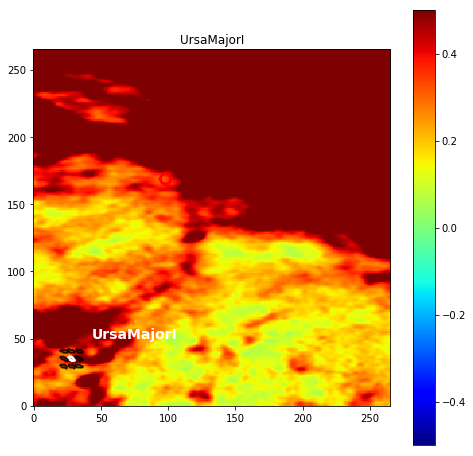

In [201]:
plt.figure(figsize=(8, 8))
im = plt.imshow(img1[tar_v, :, :], cmap='jet', origin='lower' , vmin=-.5, vmax=.5)
plt.contour(ep1, colors='white')
plt.contour(ep2, colors='r')
plt.text(tar_x+15, tar_y+15, objname, color='w', fontsize=14, weight='semibold')
plt.title(objname)
plt.colorbar(im)

#outline of 8 surrounding ellipses
plt.contour(ep_1, colors='k', alpha=.3)
plt.contour(ep_2, colors='k', alpha=.3)
plt.contour(ep_3, colors='k', alpha=.3)
plt.contour(ep_4, colors='k', alpha=.3)
plt.contour(ep_5, colors='k', alpha=.3)
plt.contour(ep_6, colors='k', alpha=.3)
plt.contour(ep_7, colors='k', alpha=.3)
plt.contour(ep_8, colors='k', alpha=.3)

#plt.xlim(0, 50)
#plt.ylim(75, 125)

#plt.savefig('/Users/amalyajohnson/Desktop/images/resolved undetected/%s_resolvedundetected.pdf'%(objname)') #to save file

plt.show()

# MHI

In [202]:
def dist(objname):
    tbm = Table.read('/Users/amalyajohnson/Desktop/astro/Dwarf Galaxies/dwarfgalcomplete_newnew.txt', format='ascii')
    for i, iname in enumerate(tbm['GalaxyName']):
        if iname == objname:
            find_it = True
            break 
        else: 
            find_it = False
        
    if find_it == True:
        dist = float(tbm['dist(kpc)'][i])
        return dist 
print(dist(objname))

None


# Resolved

In [ ]:
tflux = 0.015822593
d = dist(objname)/1e3
tmasssolar = ((tflux)*hdr['CDELT3']/1000.*1.823e18)*np.fabs(np.cos(objDEC*np.pi/180.))*(hdr['CDELT2']*np.pi/180.*d*u.pc.in_units('cm')*1e6)**2*1.6727e-24/1.99e33       
tmasssolar

# Table: hi4pi_resolved_undetected_table.txt

In [207]:
#tbnew = Table(names=('GalaxyName', 'med_std', 'v_-5', 'v_-4', 'v_-3', 'v_-2', 
#                      'v_-1', 'v_0', 'v_+1', 'v_+2', 'v_+3', 'v_+4', 'v_+5'), 
#             meta={'name': 'first table'},
#              dtype=('<U11', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8'))
#tbnew.add_row(rowd)

tb = Table.read('/Users/amalyajohnson/Desktop/astro/Dwarf Galaxies/hi4pi_resolved_undetected_table.txt', format='ascii')
tb.add_row(rowd)

f = open('hi4pi_resolved_undetected_table.txt', 'w')
table = tb
f.write(tabulate(tb))
f.close


GalaxyName,med_std,v_-5,v_-4,v_-3,v_-2,v_-1,v_0,v_+1,v_+2,v_+3,v_+4,v_+5
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
UrsaMajorII,0.33041,0.29192,0.2907,0.29266,0.39312,0.52351,0.51525,0.36989,0.29312,0.32788,0.34514,0.33041
Tucana2,0.11744,0.13279,0.1321,0.09946,0.07456,0.08875,0.11781,0.13724,0.12786,0.10454,0.10228,0.11744
Tucana2,0.11744,0.13279,0.1321,0.09946,0.07456,0.08875,0.11781,0.13724,0.12786,0.10454,0.10228,0.11744
Draco,0.21153,0.12404,0.10974,0.1389,0.15178,0.21153,0.28788,0.29272,0.25904,0.24986,0.213,0.14644
SextansI,0.57736,0.42631,0.48201,0.57736,0.65398,0.65606,0.67766,0.70233,0.59833,0.49953,0.5653,0.52435
UrsaMajorI,1.12877,0.75418,0.87294,0.96666,1.03453,1.08105,1.12877,1.20459,1.30527,1.38664,1.41153,1.4108
UrsaMajorI,1.12877,0.75418,0.87294,0.96666,1.03453,1.08105,1.12877,1.20459,1.30527,1.38664,1.41153,1.4108
UrsaMajorI,1.12877,0.75418,0.87294,0.96666,1.03453,1.08105,1.12877,1.20459,1.30527,1.38664,1.41153,1.4108
UrsaMajorI,1.12877,0.75418,0.87294,0.96666,1.03453,1.08105,1.12877,1.20459,1.30527,1.38664,1.41153,1.4108


# Old

In [ ]:
x = 0  #x = 0 : just looking at central velocity channel, x = 10, going through +/- 5 velocity channels
full_chan = tar_v + np.arange(x+1) - ceil(x/2) #summing flux through +/- x/2 velocity channels 



def fluxi(objname, epi): #Function to produce an array of total flux through each ellipse

    vrange = []
    vrange_tflux = []
    for f in full_chan:                  #f goes from -full_chan/2 to full_chan/2
        v_chan = img1[f][epi]
        v_tflux = np.nansum(v_chan)      #sum of flux through ellipse "i" in velocity channel "f"
        vrange.append(v_chan)
        vrange_tflux.append(v_tflux)
        #ttflux = np.nansum(vrange_tflux) #total flux through all 10 velocity channels 
    return vrange_tflux

tflux_8ep = []
for epi in [ep1, ep_1, ep_2, ep_3, ep_4, ep_5, ep_6, ep_7, ep_8]:
    
    tflux = np.nansum(fluxi(objname, epi))  #calling fluxi on ellipses 1 through 8, ep1 = central location 
    tflux_8ep.append(tflux)                 #putting this result into array for 8 ellipses
    

np.nanstd(tflux_8ep)  #standard deviation of 9 ellipses (last column in table)
    
#array of object name, standard deviation of 9 ellipses, and total flux of each ellipse 
#rowf = ([objname, '%.5f'%(np.nanstd(tflux_8ep)),'%.5f'%(fluxi(objname, ep1)), 
#         '%.5f'%(fluxi(objname, ep_1)), '%.5f'%(fluxi(objname, ep_2)), '%.5f'%(fluxi(objname, ep_3)),
#         '%.5f'%(fluxi(objname, ep_4)), '%.5f'%(fluxi(objname, ep_5)), '%.5f'%(fluxi(objname, ep_6)),
#         '%.5f'%(fluxi(objname, ep_7)),'%.5f'%(fluxi(objname, ep_8))])  


np.nanstd(tflux_8ep)
#rowf, np.nanstd(tflux_8ep), np.nanstd(img1[tar_v][ep1])

fluxi(objname, ep1), np.nansum(a) #, tflux_8ep, np.nanstd(tflux_8ep)
